# Trabajo de Mentoria - DiploDatos

**Grupo A**
    
Integrantes: 
    <li> Bruno Garcia
    <li> Nicolas Chiapello
    <li> Martin Peñas
    <li> Pamela E. Pairo

## Vectorización: Tfidf

El conteo de la frecuencia de las palabras tiene la desventaja que palabras como “the”, “a”, “is” en inglés, son muy frecuentes y son poco informativas sobre el contenido real del documento.
Una alternativa que suele utilizarse es emplear Tfidf. Tf significa término de frecuencia mientras que tf-idf significa término de frecuencia multiplicado por la frecuencia inversa del documento.

A lo largo de esta notebook se presentan los resultados de diferentes algoritmos de machine learning vectorizando el dataset de sentimientos para luego compararlos con la vectorización usando CountVectorizar.

Primero, se carga la base de datos procesada en `01_preprocesamiento.ipynb`.

In [1]:
import pandas as pd 
import numpy as np

df_news= pd.read_csv("data/feeling_procesado.csv").drop(columns="Unnamed: 0")
df_news.head(3)

,feeling,news,news_tokens,news_tokens_tagged
0,neutral,"According to Gran , the company has no plans t...","['accord', 'gran', 'company', 'plan', 'move', ...","[('accord', 'NN'), ('gran', 'VBD'), ('company'..."
1,neutral,Technopolis plans to develop in stages an area...,"['technopolis', 'plan', 'develop', 'stage', 'a...","[('technopolis', 'NN'), ('plan', 'NN'), ('deve..."
2,negative,The international electronic industry company ...,"['international', 'electronic', 'industry', 'c...","[('international', 'JJ'), ('electronic', 'JJ')..."


## Palabras mas asociadas a cada sentimiento

Se analiza mediante una prueba de $\chi^2$ las palabras que están asociadas a cada nivel de sentimiento

In [3]:
from sklearn.model_selection import train_test_split

category_codes = {
    'neutral': 0,
    'negative': 1,
    'positive': 2
}

df_news['Category_Code'] = df_news['feeling'].map(category_codes)

X_train, X_test, y_train, y_test = train_test_split(df_news.news_tokens, df_news.Category_Code, test_size=0.2, random_state=42)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(#ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        norm='l2')
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(3870, 6655)
(968, 6655)


In [5]:
from sklearn.feature_selection import chi2

for noticia, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    #bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' sentimiento:".format(noticia))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-7:])))
   # print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'negative' sentimiento:
  . Most correlated unigrams:
. drop
. profit
. loss
. eur
. fell
. mn
. decrease

# 'neutral' sentimiento:
  . Most correlated unigrams:
. rise
. loss
. compare
. period
. profit
. mn
. eur

# 'positive' sentimiento:
  . Most correlated unigrams:
. mn
. positive
. improve
. eur
. grow
. increase
. rise



Se realizo una nube de palabras para cada nivel de sentimiento con el objetivo de identificar las palabras que mas importantes a lo largo de los documentos. Según Tfidf, la ocurrencia de una palabra aumenta su importancia pero su aparición en múltiples documentos la reduce. De esta forma las palabras que se muestran en las nubes de palabras tienen una frecuencia alta y son utilizadas en relativamente pocas noticias. 

In [14]:
condicion_p= df_news["feeling"]== "positive"

positive_df=df_news[condicion_p]

In [15]:
condicion_n= df_news["feeling"]== "neutral"

neutral_df=df_news[condicion_n]

In [16]:
condicion_neg= df_news["feeling"]== "negative"

negative_df=df_news[condicion_neg]

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

def get_most_important_words_tdif(text):
  vectorizer = TfidfVectorizer()
  tfidf_count_occurs = vectorizer.fit_transform(text)
  tfidf_count_occur_df = pd.DataFrame(
      (count, word) for word, count in zip(
      tfidf_count_occurs.toarray().tolist()[0],   
      vectorizer.get_feature_names()))
  tfidf_count_occur_df.columns = ['Word', 'Count']
  tfidf_count_occur_df.sort_values('Count', ascending=False, inplace=True)
  return vectorizer, tfidf_count_occur_df


def plot_word_cloud(data_df, title):
  fig, ax = plt.subplots(1,2, figsize=(30,10))
  plot_data = {data["Word"]:data["Count"] for index, data in  data_df.iterrows()}
  
  wc = WordCloud(background_color="white", max_words=1000, width=800, height=400)
  wc.generate_from_frequencies(plot_data)
  ax[0].imshow(wc, interpolation='bilinear')
  
  sns.barplot(data=data_df[:10], x="Word", y="Count", ax=ax[1])
  fig.suptitle(title, size=25)
  
  ax[0].axis("off")
  plt.show()

In [18]:
model_tdif, word_positive=get_most_important_words_tdif(positive_df.news_tokens)

In [19]:
model_tdif, word_neutral=get_most_important_words_tdif(neutral_df.news_tokens)

In [20]:
model_tdif, word_negative=get_most_important_words_tdif(negative_df.news_tokens)

In [21]:
word_positive["clean_count"] = pd.to_numeric(word_positive["Count"] * 1000)
word_neutral["clean_count"] = pd.to_numeric(word_neutral["Count"] * 1000)
word_negative["clean_count"] = pd.to_numeric(word_negative["Count"] * 1000)

In [22]:
word_neutral=word_neutral.dropna()

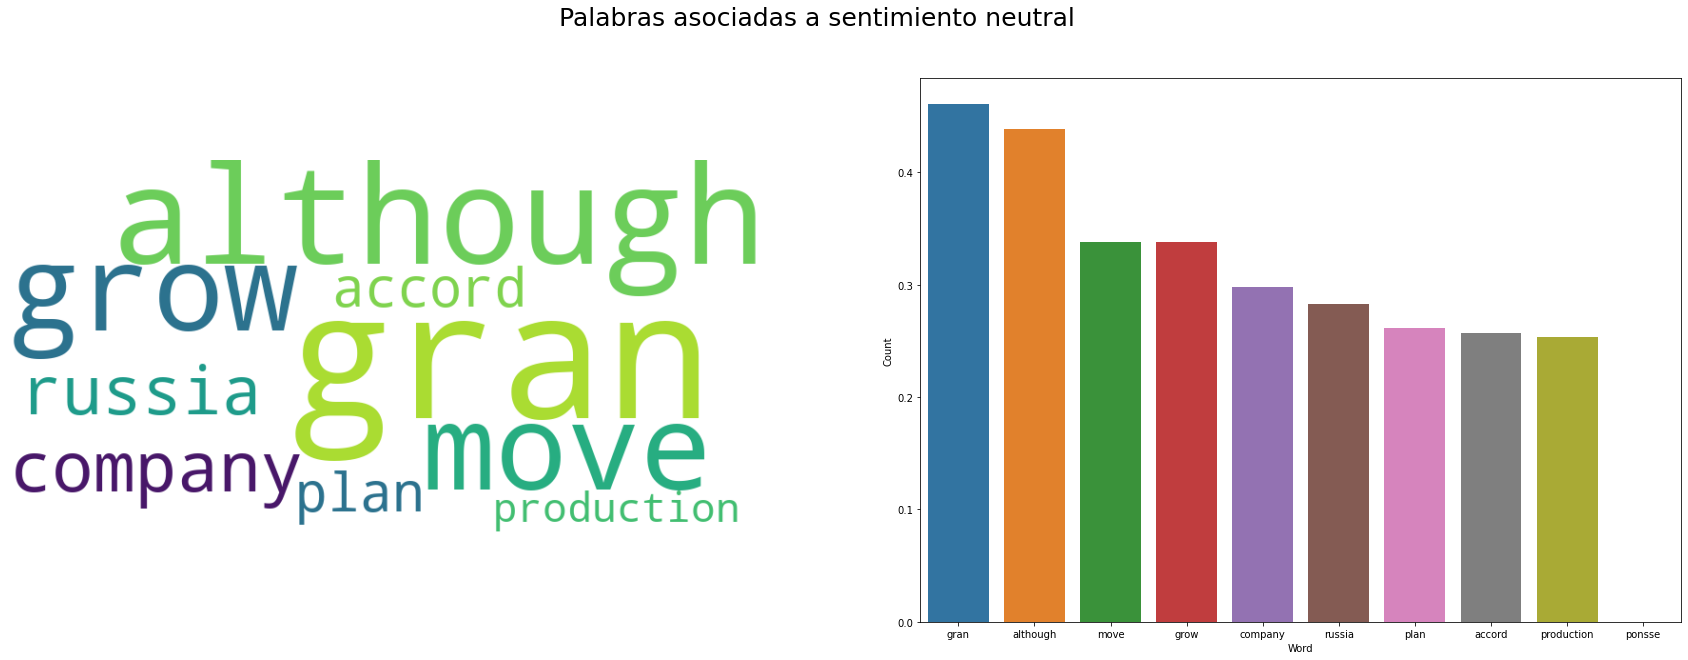

In [29]:
 plot_word_cloud(word_neutral, "Palabras asociadas a sentimiento neutral")

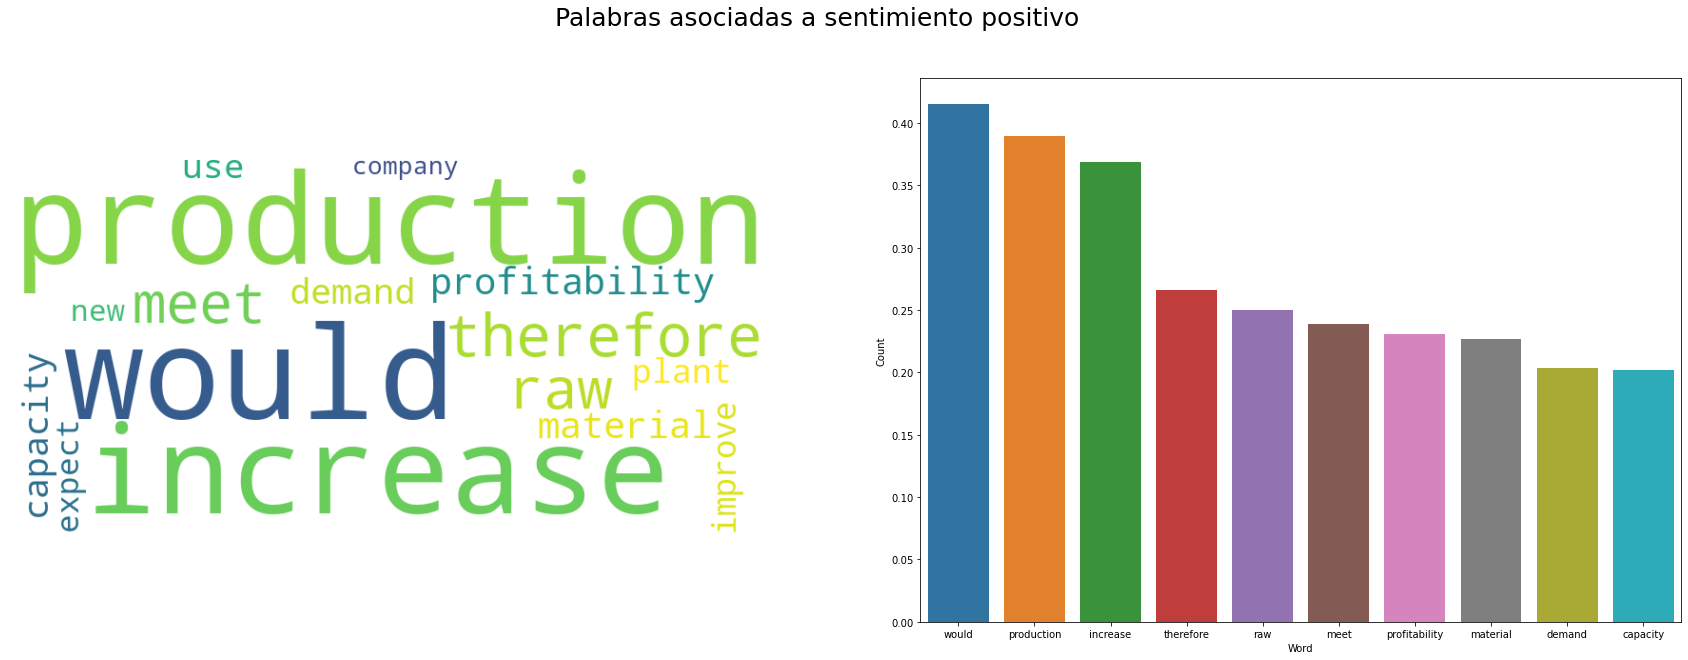

In [30]:
 plot_word_cloud(word_positive, "Palabras asociadas a sentimiento positivo")

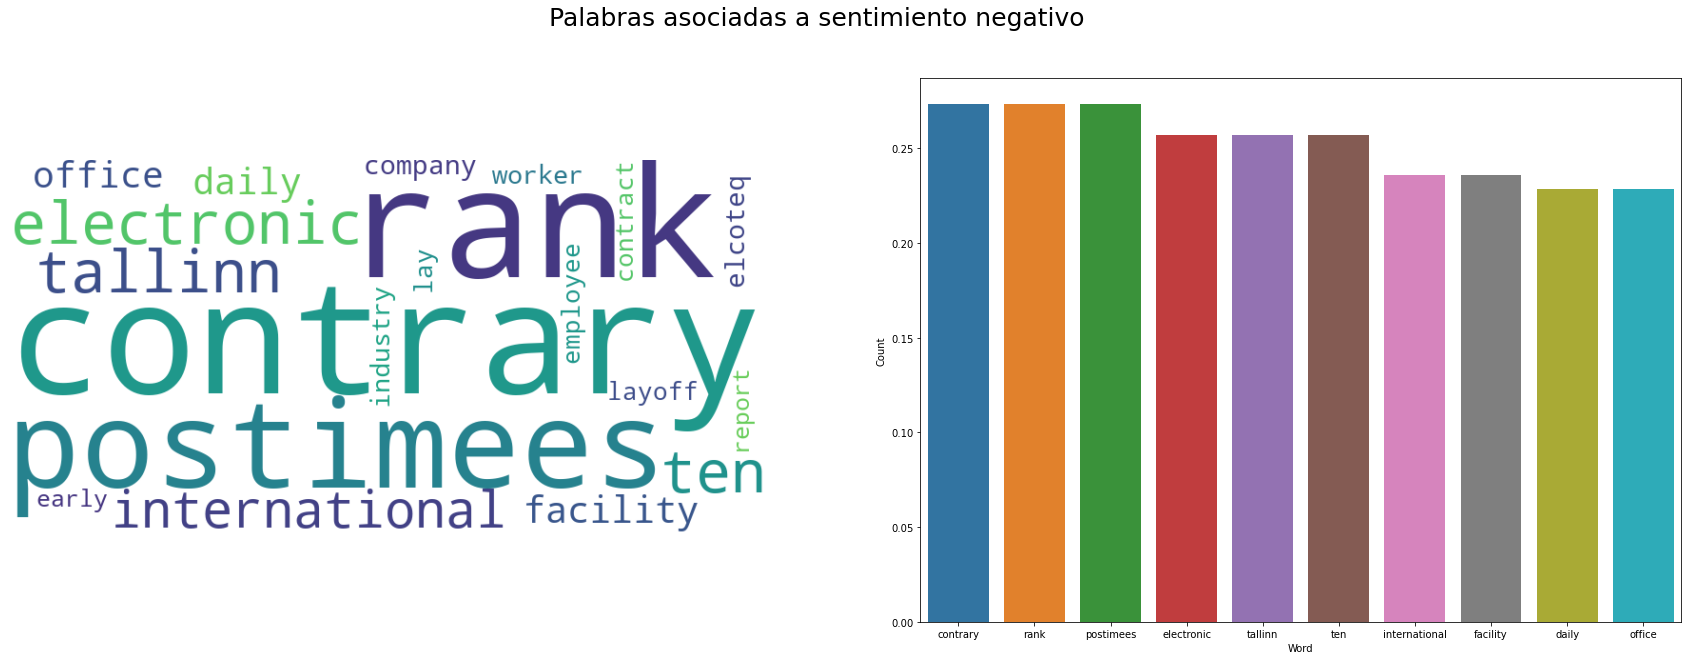

In [31]:
 plot_word_cloud(word_negative, "Palabras asociadas a sentimiento negativo")

## Aprendizaje Automático

A continuación se muestran los resultados obtenidos para la clasificación de los sentimientos según algunos algoritmos seleccionados. Se definió como baseline a la regresión logística. Se hizo una búsqueda de los hiperparámetros utilizando GridSearchCV y BayesSearchCV. En la búsqueda bayesiana, se especifica un rango o espacio sobre los parámetros que se desean encontrar. Este espacio se recorre de manera apropiada recordando iteraciones pasadas de busqueda hasta encontrar el modelo óptimo.Dado que se tienen 3 clases que se quieren predecir, se eligió como al mejor modelo aquel que tenga el score F1 más alto.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_news.news_tokens, df_news.feeling, test_size=0.2, random_state=42)

Se seleccionan las 300 palabras mas frecuentes a lo largo de todos los documentos.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_features = 300

tfidf = TfidfVectorizer(#ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        #max_features=max_features,
                        norm='l2')
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(3870, 6655)
(968, 6655)


In [35]:
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')

## Regresión Logística

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Selección de parámetros
params = {
    'penalty':['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

Logreg = LogisticRegression()
Logreg_clf = GridSearchCV(Logreg, params, cv=3, scoring='f1_macro', n_jobs=-1)
Logreg_clf.fit(features_train, labels_train)

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1_macro')

In [37]:
best_Logreg = Logreg_clf.best_estimator_
print(best_Logreg)

LogisticRegression(penalty='none', solver='saga')


In [38]:
text = "Regresión Logística - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(labels_test, best_Logreg.predict(features_test)))

Regresión Logística - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.58      0.51      0.54       120
     neutral       0.80      0.82      0.81       575
    positive       0.67      0.67      0.67       273

    accuracy                           0.74       968
   macro avg       0.68      0.67      0.67       968
weighted avg       0.74      0.74      0.74       968



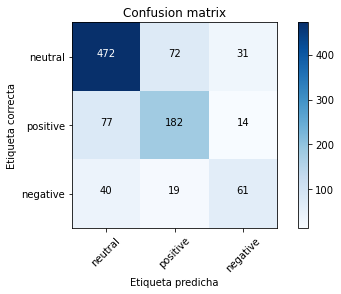

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_test, best_Logreg.predict(features_test),
                      labels=['neutral', 'positive', 'negative'])
plot_confusion_matrix(cm, ['neutral', 'positive', 'negative'])

## Naive Bayes

In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [1.0, 0.5, 0.1, 0.01, 0.001, 0.0001],
    'fit_prior': [1, 0],
    'class_prior': [None, [0.33, 0.34, 0.33], [0.12790698, 0.58914729, 0.28294574]]
}

multinomNB = MultinomialNB()
multinomNB_clf = GridSearchCV(multinomNB, param_grid, scoring='f1_macro', cv=3)
multinomNB_clf.fit(features_train, labels_train)

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [1.0, 0.5, 0.1, 0.01, 0.001, 0.0001],
                         'class_prior': [None, [0.33, 0.34, 0.33],
                                         [0.12790698, 0.58914729, 0.28294574]],
                         'fit_prior': [1, 0]},
             scoring='f1_macro')

In [41]:
best_multinomNB = multinomNB_clf.best_estimator_
best_multinomNB

MultinomialNB(alpha=0.1, class_prior=[0.12790698, 0.58914729, 0.28294574],
              fit_prior=1)

In [42]:
from sklearn.metrics import classification_report
text = "Naive Bayes - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(labels_test, best_multinomNB.predict(features_test)))

Naive Bayes - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.60      0.44      0.51       120
     neutral       0.74      0.87      0.80       575
    positive       0.60      0.45      0.52       273

    accuracy                           0.70       968
   macro avg       0.65      0.59      0.61       968
weighted avg       0.68      0.70      0.68       968



## BayesSearch

In [43]:
from sklearn.naive_bayes import MultinomialNB
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_bayes_nv = {
    'alpha': Real(0.001, 1.0),
    'fit_prior': Categorical([False])
    #'class_prior': Real([[0.33, 0.34, 0.33]])
}

multinomNB = MultinomialNB(class_prior=[0.12790698, 0.58914729, 0.28294574])
multinomNB_bayes = BayesSearchCV(multinomNB, param_bayes_nv, scoring='f1_macro', cv=3)
multinomNB_bayes.fit(features_train, labels_train)

BayesSearchCV(cv=3,
              estimator=MultinomialNB(class_prior=[0.12790698, 0.58914729,
                                                   0.28294574]),
              scoring='f1_macro',
              search_spaces={'alpha': Real(low=0.001, high=1.0, prior='uniform', transform='identity'),
                             'fit_prior': Categorical(categories=(False,), prior=None)})

In [44]:
best_multinomNB_bayes = multinomNB_bayes.best_estimator_
best_multinomNB_bayes

MultinomialNB(alpha=0.06804906668873352,
              class_prior=[0.12790698, 0.58914729, 0.28294574],
              fit_prior=False)

In [45]:
text = "Naive Bayes - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(labels_test, best_multinomNB_bayes.predict(features_test)))

Naive Bayes - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.61      0.48      0.54       120
     neutral       0.74      0.86      0.80       575
    positive       0.61      0.45      0.52       273

    accuracy                           0.70       968
   macro avg       0.65      0.60      0.62       968
weighted avg       0.69      0.70      0.69       968



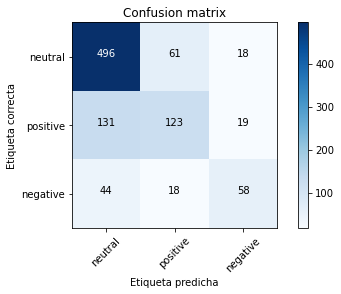

In [46]:
cm = confusion_matrix(labels_test, best_multinomNB_bayes.predict(features_test),
                      labels=['neutral', 'positive', 'negative'])
plot_confusion_matrix(cm, ['neutral', 'positive', 'negative'])

## SVM

In [47]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["auto", "scale"],
    "C": [1,10,20]
}

svm = SVC()
svm_clf = GridSearchCV(svm, params, cv=3, scoring='f1_macro', n_jobs=-1)
svm_clf.fit(features_train, labels_train)

best_svm = svm_clf.best_estimator_

In [48]:
print(best_svm)

SVC(C=1, gamma='auto', kernel='linear')


In [49]:
from sklearn.metrics import classification_report
text = "SVM - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(labels_test, best_svm.predict(features_test)))

SVM - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.65      0.55      0.60       120
     neutral       0.78      0.88      0.82       575
    positive       0.71      0.56      0.63       273

    accuracy                           0.75       968
   macro avg       0.71      0.66      0.68       968
weighted avg       0.74      0.75      0.74       968



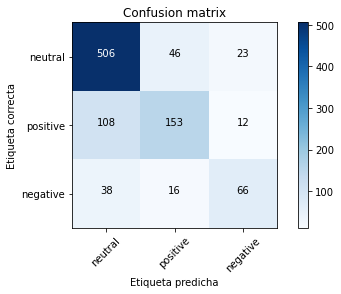

In [50]:
cm = confusion_matrix(labels_test, best_svm.predict(features_test),
                      labels=['neutral', 'positive', 'negative'])
plot_confusion_matrix(cm, ['neutral', 'positive', 'negative'])

## BayesSearch

In [39]:
params_bayes_svm = {
    "kernel": Categorical(["linear", "poly", "rbf", "sigmoid"]),
    "gamma": Categorical(["auto", "scale"]),
    "C": Integer(1,30)
}

svm = SVC()
svm_clf_bayes = BayesSearchCV(svm, params_bayes_svm, cv=3, scoring='f1_macro', n_jobs=-1)
svm_clf_bayes.fit(features_train, labels_train)

best_svm_bayes = svm_clf_bayes.best_estimator_

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

In [40]:
print(best_svm_bayes)

SVC(C=4, kernel='linear')


In [41]:
text = "SVM - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(labels_test, best_svm_bayes.predict(features_test)))

SVM - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.55      0.46      0.50       120
     neutral       0.76      0.88      0.81       575
    positive       0.68      0.51      0.58       273

    accuracy                           0.72       968
   macro avg       0.66      0.62      0.63       968
weighted avg       0.71      0.72      0.71       968



## Random Forest

In [51]:
param_grid = {
    'max_depth': [10, 30, 60],
    'criterion':['gini', 'entropy'],
    'min_samples_split': [2, 4, 8, 10],
    'min_samples_leaf':[2, 5, 10],
    'n_estimators': [10, 20, 40, 50]
   
}

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix,f1_score, make_scorer

# First create the base model to tune
rfc = RandomForestClassifier(random_state=42)
scorer = make_scorer(f1_score, average = "macro")

# Definition of the random search
random_search = GridSearchCV(estimator=rfc,
                             param_grid=param_grid,
                             scoring= scorer,
                             cv=3)

# Fit the random search model
random_search.fit(features_train, labels_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 30, 60],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 4, 8, 10],
                         'n_estimators': [10, 20, 40, 50]},
             scoring=make_scorer(f1_score, average=macro))

In [53]:
random_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=60, min_samples_leaf=2,
                       min_samples_split=8, n_estimators=10, random_state=42)

In [54]:
best_rfc = random_search.best_estimator_

In [55]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(criterion='entropy', max_depth=60, min_samples_leaf=2,
                       min_samples_split=8, n_estimators=10, random_state=42)

In [56]:
rfc_pred = best_rfc.predict(features_test)

In [57]:
text = "Random Forest - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")

print(classification_report(labels_test,rfc_pred))

Random Forest - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.78      0.21      0.33       120
     neutral       0.72      0.94      0.81       575
    positive       0.62      0.42      0.50       273

    accuracy                           0.70       968
   macro avg       0.71      0.52      0.55       968
weighted avg       0.70      0.70      0.66       968



## BayesSearch

In [49]:
param_bayes_rfc = {
    'max_depth': Integer(10, 75),
    'criterion':Categorical(['gini', 'entropy']),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf':Integer(1, 10),
    'n_estimators': Integer(5, 60)
   
}

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix,f1_score, make_scorer

# First create the base model to tune
rfc = RandomForestClassifier(random_state=42)
scorer = make_scorer(f1_score, average = "macro")

# Definition of the random search
bayes_search = BayesSearchCV(rfc,
                             param_bayes_rfc,
                             scoring= scorer,
                             cv=3)

# Fit the random search model
bayes_search.fit(features_train, labels_train)

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
              scoring=make_scorer(f1_score, average=macro),
              search_spaces={'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=10, high=75, prior='uniform', transform='identity'),
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'),
                             'min_samples_split': Integer(low=2, high=15, prior='uniform', transform='identity'),
                             'n_estimators': Integer(low=5, high=60, prior='uniform', transform='identity')})

In [51]:
bayes_search.best_estimator_

RandomForestClassifier(max_depth=61, n_estimators=60, random_state=42)

In [52]:
best_rfc = bayes_search.best_estimator_

In [53]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(max_depth=61, n_estimators=60, random_state=42)

In [54]:
rfc_pred = best_rfc.predict(features_test)

In [55]:
text = "Random Forest - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")

print(classification_report(labels_test,rfc_pred))

Random Forest - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.66      0.35      0.46       120
     neutral       0.74      0.91      0.82       575
    positive       0.65      0.47      0.55       273

    accuracy                           0.72       968
   macro avg       0.68      0.58      0.61       968
weighted avg       0.71      0.72      0.70       968



## KNeighborsClassifier

In [58]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    "n_neighbors": [1,5,15,20],
    "weights": ["uniform", "distance"],
    "algorithm":["auto", "ball_tree", "kd_tree", "brute"]
}

knn = KNeighborsClassifier()
knn_clf= GridSearchCV(knn, params, cv=3, scoring='f1_macro', n_jobs=-1)
knn_clf.fit(features_train, labels_train)

best_knn = knn_clf.best_estimator_

In [59]:
print(best_knn)

KNeighborsClassifier(algorithm='brute', n_neighbors=15, weights='distance')


In [60]:
text = "KNN - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")

print(classification_report(labels_test, best_knn.predict(features_test)))

KNN - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.62      0.38      0.47       120
     neutral       0.75      0.89      0.81       575
    positive       0.60      0.45      0.52       273

    accuracy                           0.71       968
   macro avg       0.65      0.57      0.60       968
weighted avg       0.69      0.71      0.69       968



## BayesSearch

In [59]:
params_knn_bayes = {
    "n_neighbors": Integer(1,20),
    "weights": Categorical(["uniform", "distance"]),
    "algorithm":Categorical(["auto", "ball_tree", "kd_tree", "brute"])
}

knn = KNeighborsClassifier()
knn_clf_bayes= BayesSearchCV(knn, params_knn_bayes, cv=3, scoring='f1_macro', n_jobs=-1)
knn_clf_bayes.fit(features_train, labels_train)

best_knn_bayes = knn_clf_bayes.best_estimator_

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

In [60]:
print(best_knn_bayes)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=3, weights='distance')


In [61]:
text = "KNN - Reporte de clasificación del conjunto de testeo"
print(len(text)*"=")
print(text)
print(len(text)*"=")

print(classification_report(labels_test, best_knn_bayes.predict(features_test)))

KNN - Reporte de clasificación del conjunto de testeo
              precision    recall  f1-score   support

    negative       0.42      0.34      0.38       120
     neutral       0.72      0.86      0.78       575
    positive       0.56      0.37      0.45       273

    accuracy                           0.66       968
   macro avg       0.57      0.52      0.54       968
weighted avg       0.64      0.66      0.64       968



In [14]:
def plot_coefficients(classifier, feature_names, top_features=60):
    coef = classifier.coef_.ravel()
    
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()

In [ ]:
plot_coefficients(best_svm, tfidf.get_feature_names())

## Conclusiones

Los resultados obtenidos utilizando Tfidf muestran que el mejor modelo fue SVM (F1=0.68). Además, se encontraron que las palabras que estuvieron mas asociadas a cada sentimiento tienen una correspondencia con el tipo de sentimiento. 

Se obtuvo un valor relativamente bajo de F1 cuando se esperaba lo contrario respecto a CountVectorizer. Una de las posibles explicaciones puede ser al desbalance de los clases de sentimientos, donde `neutral` es la que posee mayor cantidad de instancias y `negative` la menor cantidad. Existen diferentes alternativas para trabajar con [datos desbalanceados](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18). Se probó unicamente otorgando pesos que sean inversamente proporcionales a la frecuencia de las clases. Para ello se especificó en cada modelo `class_weight='balanced'` aunque no se logró aumentar F1. Por otra parte, quizas se podrían obtener valores mas altos de F1 con otros algoritmos tales como xgboost o con redes neuronales.

Respecto a la asociación de las palabras con los niveles de sentimientos, se observa coherencia entre las palabras asociadas a sentimiento negativo (ej. loss, drop, fell, decrease) y positivo (ej. positive, improve, grow, increase, rise). Sin embargo, algunas palabras que estuvieron mas asociadas a sentimiento neutral fueron las mismas que estuvieron asociadas a resto de los sentimientos (ej. rise, loss). Probablemente esto pudo haber ocasionado cierta dificultad en clasificar los niveles de sentimientos y por ende el bajo valor de F1.

Finalmente, el análisis de las nubes de palabras muestra cierta correspondencia con los resultados de la asociación entre palabras y los sentimientos. Se destaca que las palabras mas frecuentes en las noticias clasificadas con sentimiento negativo aparecieron palabras como "tallin", "postimees" y "elcoteq"; todas ellas relacionadas con Estonia. Elcoteq Tallinn, la filial estonia de la empresa finlandesa Elcoteq, anunció en el año 2009 el despido de 166 empleados debido a la adquisición de dicha empresa por parte de Ericsson. Este evento pudo haber generado la alta frecuencia de las palabras anteriormente mencionadas.